<a href="https://colab.research.google.com/github/Adlucent/ga4-churn-prediction/blob/main/VI_Multicollinearity_Check_and_Model_Building%2C_Tuning_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VI. Multicollinearity Check and Model Building
1. Check for multicollinearity using the Variance Inflation Factor function
2. Remove features with high VIF score
3. Scale data and perform Train/Val/Test split
4. Upsample and downsample
5. Perform Cross validation on several Churn Classifier models
6. Model fitting
7. Model tuning
8. Model evaluation
9. Key feature analysis

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'adl-analytics' #add proj name
region = "US"  # GCP project region

In [ ]:
# Google credentials 
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics 
'''BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI '''

from google.cloud import bigquery
from google.cloud.bigquery import magics, Client, QueryJobConfig

magics.context.project = project_name
client = bigquery.Client(project=magics.context.project)

# suppress notebook warnings
import warnings
warnings.filterwarnings('ignore')

# data processing
import pandas as pd
import numpy as np
from datetime import date, timedelta, timezone

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# undersampling and oversampling libraries
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# model evaluation metrics
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# data scaling, train/test split and cross-validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# Import classifier models
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# Creating pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# dataframe formatting
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

## Import data from BigQuery
Import the final aggregated table saved at the end of the last notebook.

In [ ]:
%%bigquery data --project $project_name 
SELECT *
FROM `adl-analytics.public_sample_data.churn_ga4_5` # update with your dataset and table name

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
# create a copy
df = data.copy()

In [ ]:
df.isnull().sum()

user_pseudo_id                                                         0
Churn_Target                                                           0
eventCount_add_payment_info                                            0
eventCount_add_shipping_info                                           0
eventCount_add_to_cart                                                 0
eventCount_begin_checkout                                              0
eventCount_click                                                       0
eventCount_first_visit                                                 0
eventCount_page_view                                                   0
eventCount_purchase                                                    0
eventCount_scroll                                                      0
eventCount_select_item                                                 0
eventCount_select_promotion                                            0
eventCount_session_start                           

In [ ]:
# since the only remaining null values are counts of occurrences for each feature, we'll impute all nan values with 0
df = df.fillna(0.0)

In [ ]:
df.isnull().sum()

user_pseudo_id                                                       0
Churn_Target                                                         0
eventCount_add_payment_info                                          0
eventCount_add_shipping_info                                         0
eventCount_add_to_cart                                               0
eventCount_begin_checkout                                            0
eventCount_click                                                     0
eventCount_first_visit                                               0
eventCount_page_view                                                 0
eventCount_purchase                                                  0
eventCount_scroll                                                    0
eventCount_select_item                                               0
eventCount_select_promotion                                          0
eventCount_session_start                                             0
eventC

## Feature Scaling and Train/Val/Test Split

In this section, we'll use sklearn's [StandardScalar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale the data (by removing the mean and scaling to unit variance), and then split into Train, Validation, and Test sets. 

In [ ]:
X = df.drop(["user_pseudo_id","Churn_Target"], axis=1).astype("float")
y = df["Churn_Target"].astype("int")

# scale all features using StandardScalar
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)

# adding constant
X = sm.add_constant(X)

# train-test-val split
# Defines ratios in the whole dataset
ratio_train = 0.7
ratio_val = 0.1
ratio_test = 0.2

# Produces test split
X_remaining, X_test, y_remaining, y_test = train_test_split(
    X, y, test_size=ratio_test, random_state = 1)

# Adjusts val ratio to 10% of original training set size
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits
X_train, X_val, y_train, y_val = train_test_split(
    X_remaining, y_remaining, test_size=ratio_val_adjusted, random_state = 1)

In [ ]:
print("Shape of Training set : ", X_train.shape)
print("Shape of Test set : ", X_test.shape)
print("Shape of Validation set : ", X_val.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))
print("Percentage of classes in validation set:")
print(y_val.value_counts(normalize=True))

Shape of Training set :  (1099, 184)
Shape of Test set :  (314, 184)
Shape of Validation set :  (157, 184)
Percentage of classes in training set:
1   0.984
0   0.016
Name: Churn_Target, dtype: float64
Percentage of classes in test set:
1   0.971
0   0.029
Name: Churn_Target, dtype: float64
Percentage of classes in validation set:
1   0.981
0   0.019
Name: Churn_Target, dtype: float64


## Checking for Multicollinearity
Using the [Variance Inflation Factor](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) (VIF) function from statsmodels, we'll check for multicollinearity and drop columns with high VIF scores by looping through VIF scores and dropping the column with the maximum score each time until all scores are below 5. We do this because each time a column is dropped, all other VIF scores must be recalculated before determining what to drop next.

In [ ]:
# first, let's take a look at VIF scores for all original veatures in X_train
vif_before = pd.DataFrame(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns,
    dtype=float,
).reset_index()
vif_before.columns = ("Feature", "VIF")
print("Before feature selection: \n\n\n")
vif_before

Before feature selection: 





,Feature,VIF
0,const,0.000
1,eventCount_add_payment_info,6802034.670
2,eventCount_add_shipping_info,3964975.761
3,eventCount_add_to_cart,129531436.395
4,eventCount_begin_checkout,21507040.298
5,eventCount_click,121077.727
6,eventCount_first_visit,187412.680
7,eventCount_page_view,2501920565.499
8,eventCount_purchase,70442.912
9,eventCount_scroll,417487769.030


We can see in the above table that many features have high VIF scores, indicating there is a large amount of multicollinearity in these features. In the step below, we'll drop columns one by one based on max VIF score, recalculate VIF scores for remaining features, then loop back through again and again until all VIF scores are less than 5.

In [ ]:
# function to calculate VIF scores and loop through to drop col with max VIF each time until all are less than 5.

def vif_and_drop(X):
  cols = X.columns
  thresh = 5.0
  features = np.arange(X.shape[1])
  dropped=True
  while dropped:
      dropped=False
      c = X[cols[features]].values
      vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

      maxloc = vif.index(max(vif))
      if max(vif) > thresh:
          print('dropping \'' + X[cols[features]].columns[maxloc] + '\' at index: ' + str(maxloc))
          features = np.delete(features, maxloc)
          dropped=True

  X = X[cols[features]]
  return X

In [ ]:
# call the function and update X_train
X_train = vif_and_drop(X_train)

dropping 'items_creative_name_not_set' at index: 103
dropping 'sum_ecom_purchase_revenue' at index: 95
dropping 'items_item_variant_not_set' at index: 149
dropping 'items_promotion_name_not_set' at index: 133
dropping 'shipping_tier_type_Rush' at index: 160
dropping 'items_item_category_Sale' at index: 121
dropping 'geo_sub_continent_Northern_America' at index: 84
dropping 'device_category_desktop' at index: 17
dropping 'device_web_browser_and_version_Chrome_87_0' at index: 60
dropping 'device_os_and_version_Web_10' at index: 47
dropping 'device_mobile_brand_model_Google_Chrome' at index: 29
dropping 'shipping_tier_provider_International' at index: 151
dropping 'sum_value' at index: 157
dropping 'session_engaged_10' at index: 155
dropping 'eventCount_page_view' at index: 7
dropping 'sum_event_value' at index: 154
dropping 'items_item_brand_Google' at index: 97
dropping 'sum_items_quantity' at index: 94
dropping 'device_category_mobile' at index: 16
dropping 'items_item_brand_not_set' a

In [ ]:
X_train.shape

(1099, 144)

In [ ]:
vif_after = pd.DataFrame(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns,
    dtype=float,
).reset_index()
vif_after.columns = ("Feature", "VIF")
print("After feature selection: \n\n{}\n")
vif_after

After feature selection: 

{}



,Feature,VIF
0,const,0.000
1,eventCount_add_payment_info,4.146
2,eventCount_begin_checkout,4.652
3,eventCount_click,1.628
4,eventCount_first_visit,1.538
5,eventCount_select_item,2.587
6,eventCount_select_promotion,1.786
7,eventCount_session_start,2.639
8,eventCount_view_search_results,3.668
9,device_category_tablet,2.367


We've reduced the number of columns **from 184 to 144**. All scores are now less than 5, so we can move on to the next step. 

Go ahead and drop all the same columns from the validation dataset.

In [ ]:
X_val = X_val[X_train.columns]

## Undersampling

Since the dataset is highly imbalanced, we'll try undersampling and oversampling to ensure both classes are equally represented. <br>

First we'll try undersampling.

In [ ]:
rus = RandomUnderSampler(random_state=1, sampling_strategy = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 1081
Before UnderSampling, counts of label '0': 18 

After UnderSampling, counts of label '1': 18
After UnderSampling, counts of label '0': 18 

After UnderSampling, the shape of train_X: (36, 144)
After UnderSampling, the shape of train_y: (36,) 



There is not enough data to use after undersampling, so we'll move on to oversampling.

# Oversampling 

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority', random_state = 1)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 1081
Before OverSampling, counts of label '0': 18 

After OverSampling, counts of label '1': 1081
After OverSampling, counts of label '0': 1081 

After OverSampling, the shape of train_X: (2162, 144)
After OverSampling, the shape of train_y: (2162,) 



The oversampled dataset looks more in line with what we want for a model.

## Functions for evaluating model performance

Since our dataset is imbalanced and we're ultimately attempting to identify all of the non-churned custoers in the test dataset (which is a small portion of total active customers), we'll start by optimizing to Specificity, which is calculated as: TN / (TN + FP). This will help us error more on the side of catching more true non-churners (True Negatives). 

You may want to optimize to a difference metric depending on the distribution of your dataset and how important False Negatives v. False Positives are to you.

In [ ]:
# function for evaluating model performance
def model_performance_sklearn(model, predictors, target):

    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
    TN = confusion_matrix(target, model.predict(predictors))[0, 0]
    Specificity = TN / (TN + FP)

    pred = model.predict(predictors)

    acc = accuracy_score(target, pred) 
    recall = recall_score(target, pred)  
    precision = precision_score(target, pred) 
    f1 = f1_score(target, pred)  

    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            "Specificity": Specificity,
        },
        index=[0],
    )

    return df_perf

In [ ]:
# confusion matrix 
def confusion_matrix_sklearn(model, predictors, target):

    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")

In [ ]:
# defining our specificity metric
def specificity_metric(y_train, y_pred):

    TP = confusion_matrix(y_train, y_pred)[1, 1]
    FP = confusion_matrix(y_train, y_pred)[0, 1]
    FN = confusion_matrix(y_train, y_pred)[1, 0]
    TN = confusion_matrix(y_train, y_pred)[0, 0]
    return (TN / (TN + FP))

scorer = metrics.make_scorer(specificity_metric, greater_is_better=True)

# Models

### First, we'll build a few different types of probabalistic classifier models using the oversampled dataset.

In [ ]:
models_over = [] 

models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Random Forest", RandomForestClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("XGBoost", XGBClassifier(random_state=1, eval_metric="auc")))

results_over = []
names_over = []

scorer = scorer

In [ ]:
print("\n" "CV Specificity Scores:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits = 5, shuffle = True, random_state = 1
    )
    cv_result = cross_val_score(
        estimator = model, X = X_train_over, y = y_train_over, scoring = scorer, cv = kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))


CV Specificity Scores:

Bagging: 1.0
Random Forest: 1.0
GBM: 1.0
Adaboost: 1.0
XGBoost: 1.0


In [ ]:
# fit models to oversampled training set
for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    print(name + " model fitted.")
    
print("\n" "Training Performance:")

for name, model in models_over:
    class_score = model_performance_sklearn(model, X_train_over, y_train_over)
    print("\n" + name)
    print(class_score)
    
print("\n" "Validation Performance:")

for name, model in models_over:
    class_score = model_performance_sklearn(model, X_val, y_val)
    print("\n" + name)
    print(class_score)

Bagging model fitted.
Random Forest model fitted.
GBM model fitted.
Adaboost model fitted.
XGBoost model fitted.

Training Performance:

Bagging
   Accuracy  Recall  Precision    F1  Specificity
0     0.998   0.996      1.000 0.998        1.000

Random Forest
   Accuracy  Recall  Precision    F1  Specificity
0     1.000   1.000      1.000 1.000        1.000

GBM
   Accuracy  Recall  Precision    F1  Specificity
0     1.000   1.000      1.000 1.000        1.000

Adaboost
   Accuracy  Recall  Precision    F1  Specificity
0     0.995   0.990      1.000 0.995        1.000

XGBoost
   Accuracy  Recall  Precision    F1  Specificity
0     0.999   0.998      1.000 0.999        1.000

Validation Performance:

Bagging
   Accuracy  Recall  Precision    F1  Specificity
0     0.962   0.981      0.981 0.981        0.000

Random Forest
   Accuracy  Recall  Precision    F1  Specificity
0     0.981   1.000      0.981 0.990        0.000

GBM
   Accuracy  Recall  Precision    F1  Specificity
0     0.981 

## XGBoost Model Tuning

These models are all still performing very poorly in correctly identifying the non-churners. We'll move forward with tuning an XGBoost model using RandomizedSearchCV.

For additional detail on XGBoost hyperparameters, see documentation [here](https://xgboost.readthedocs.io/en/stable/parameter.html). 


In [ ]:
Model = XGBClassifier(
    objective = 'binary:logistic',
    random_state = 1,
    eval_metric = 'auc', 
    n_jobs = -1
)

# parames to pass in RandomizedSearchCV
param_grid={'n_estimators':np.arange(50,500,50),
            'max_depth': [3,4,5],
            'learning_rate':[0.1,0.2,0.3], 
            'gamma':[1,2,3,4,5], 
            'subsample':[0.6,0.7,0.8,0.9],
            'colsample_bytree': [0.6,0.7,0.8,0.9],
            "min_child_weight": [1,2,3]
           }

xgb_tuned = RandomizedSearchCV(
    estimator = Model, 
    param_distributions = param_grid, 
    n_iter = 50, 
    scoring = scorer, 
    cv = 5, 
    random_state = 1
)

# fitting params from RandomizedSearchCV
xgb_tuned.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(xgb_tuned.best_params_,xgb_tuned.best_score_))

Best parameters are {'subsample': 0.6, 'scale_pos_weight': 1, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 5, 'colsample_bytree': 0.9} with CV score=1.0:


In [ ]:
xgb = XGBClassifier(
    objective = 'binary:logistic',
    random_state = 1,
    eval_metric = "auc",
    n_estimators = 300,
    max_depth = 5,
    scale_pos_weight = 0.03, # scale class weight here
    learning_rate = 0.3,
    gamma = 5,
    subsample = 0.6,
    colsample_bytree = 0.9,
    min_child_weight = 3,
    n_jobs = -1
)

xgb.fit(X_train_over, y_train_over)

XGBClassifier(colsample_bytree=0.9, eval_metric='auc', gamma=5,
              learning_rate=0.3, max_depth=5, min_child_weight=3,
              n_estimators=300, n_jobs=-1, random_state=1,
              scale_pos_weight=0.03, subsample=0.6)

In [ ]:
xgb_performance_train_over = model_performance_sklearn(xgb, X_train_over, y_train_over)
xgb_performance_val_over = model_performance_sklearn(xgb, X_val, y_val)

In [ ]:
print("Train (Oversampled):")
print(xgb_performance_train_over)
print("")
print("Validation:")
print(xgb_performance_val_over)

Train (Oversampled):
   Accuracy  Recall  Precision    F1  Specificity
0     0.698   0.395      1.000 0.566        1.000

Validation:
   Accuracy  Recall  Precision    F1  Specificity
0     0.363   0.364      0.966 0.528        0.333


Train (Oversampled):


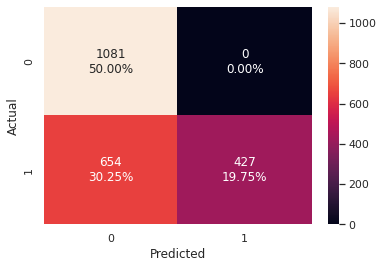

In [ ]:
print("Train (Oversampled):")
confusion_matrix_sklearn(xgb, X_train_over, y_train_over)

Validation:


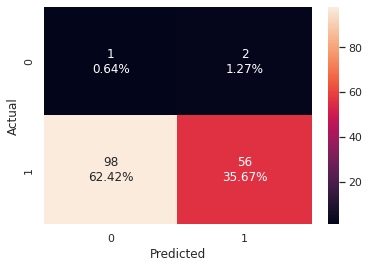

In [ ]:
print("Validation:")
confusion_matrix_sklearn(xgb, X_val, y_val)

Even though performance of this model looks bad, we only have three Negative values (non-churners) in the validation dataset. This sample GA4 data set is not quite large enough for building a model, but when using your real data, model performance should improve on the validation set. 

If you have a very large amount of data, you can train a few AutoML models (which are DNNs) from within Vertex AI's Training console. See links in the READ.me for further info on GCP resources. 

Now we'll test our model on test set to see how it does.

## Model Testing and Selection

First, drop the same columns from the test data that we dropped earlier in the X_train and X_val tables.

In [ ]:
X_test = X_test[X_train.columns]

Next, evaluate performance on the test data.

Test performance (XGB Oversampled model):
   Accuracy  Recall  Precision    F1  Specificity
0     0.366   0.351      0.991 0.518        0.889


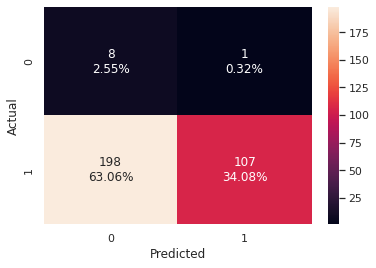

In [ ]:
xgb_performance_test = model_performance_sklearn(xgb, X_test, y_test)
print("Test performance (XGB Oversampled model):")
print(xgb_performance_test)
confusion_matrix_sklearn(xgb, X_test, y_test)

The model performed much better on the test data than on the validation data. You can continue tuning your model until you're satisfied with its performance, but be careful not to overfit too much to the current datasets. Once you've tried your model on the test set, it is best not to continue tuning (unless using AutoML) due to potential overfitting to the test set as well.

## Important features

Let's take a look at the features that influenced our model the most.

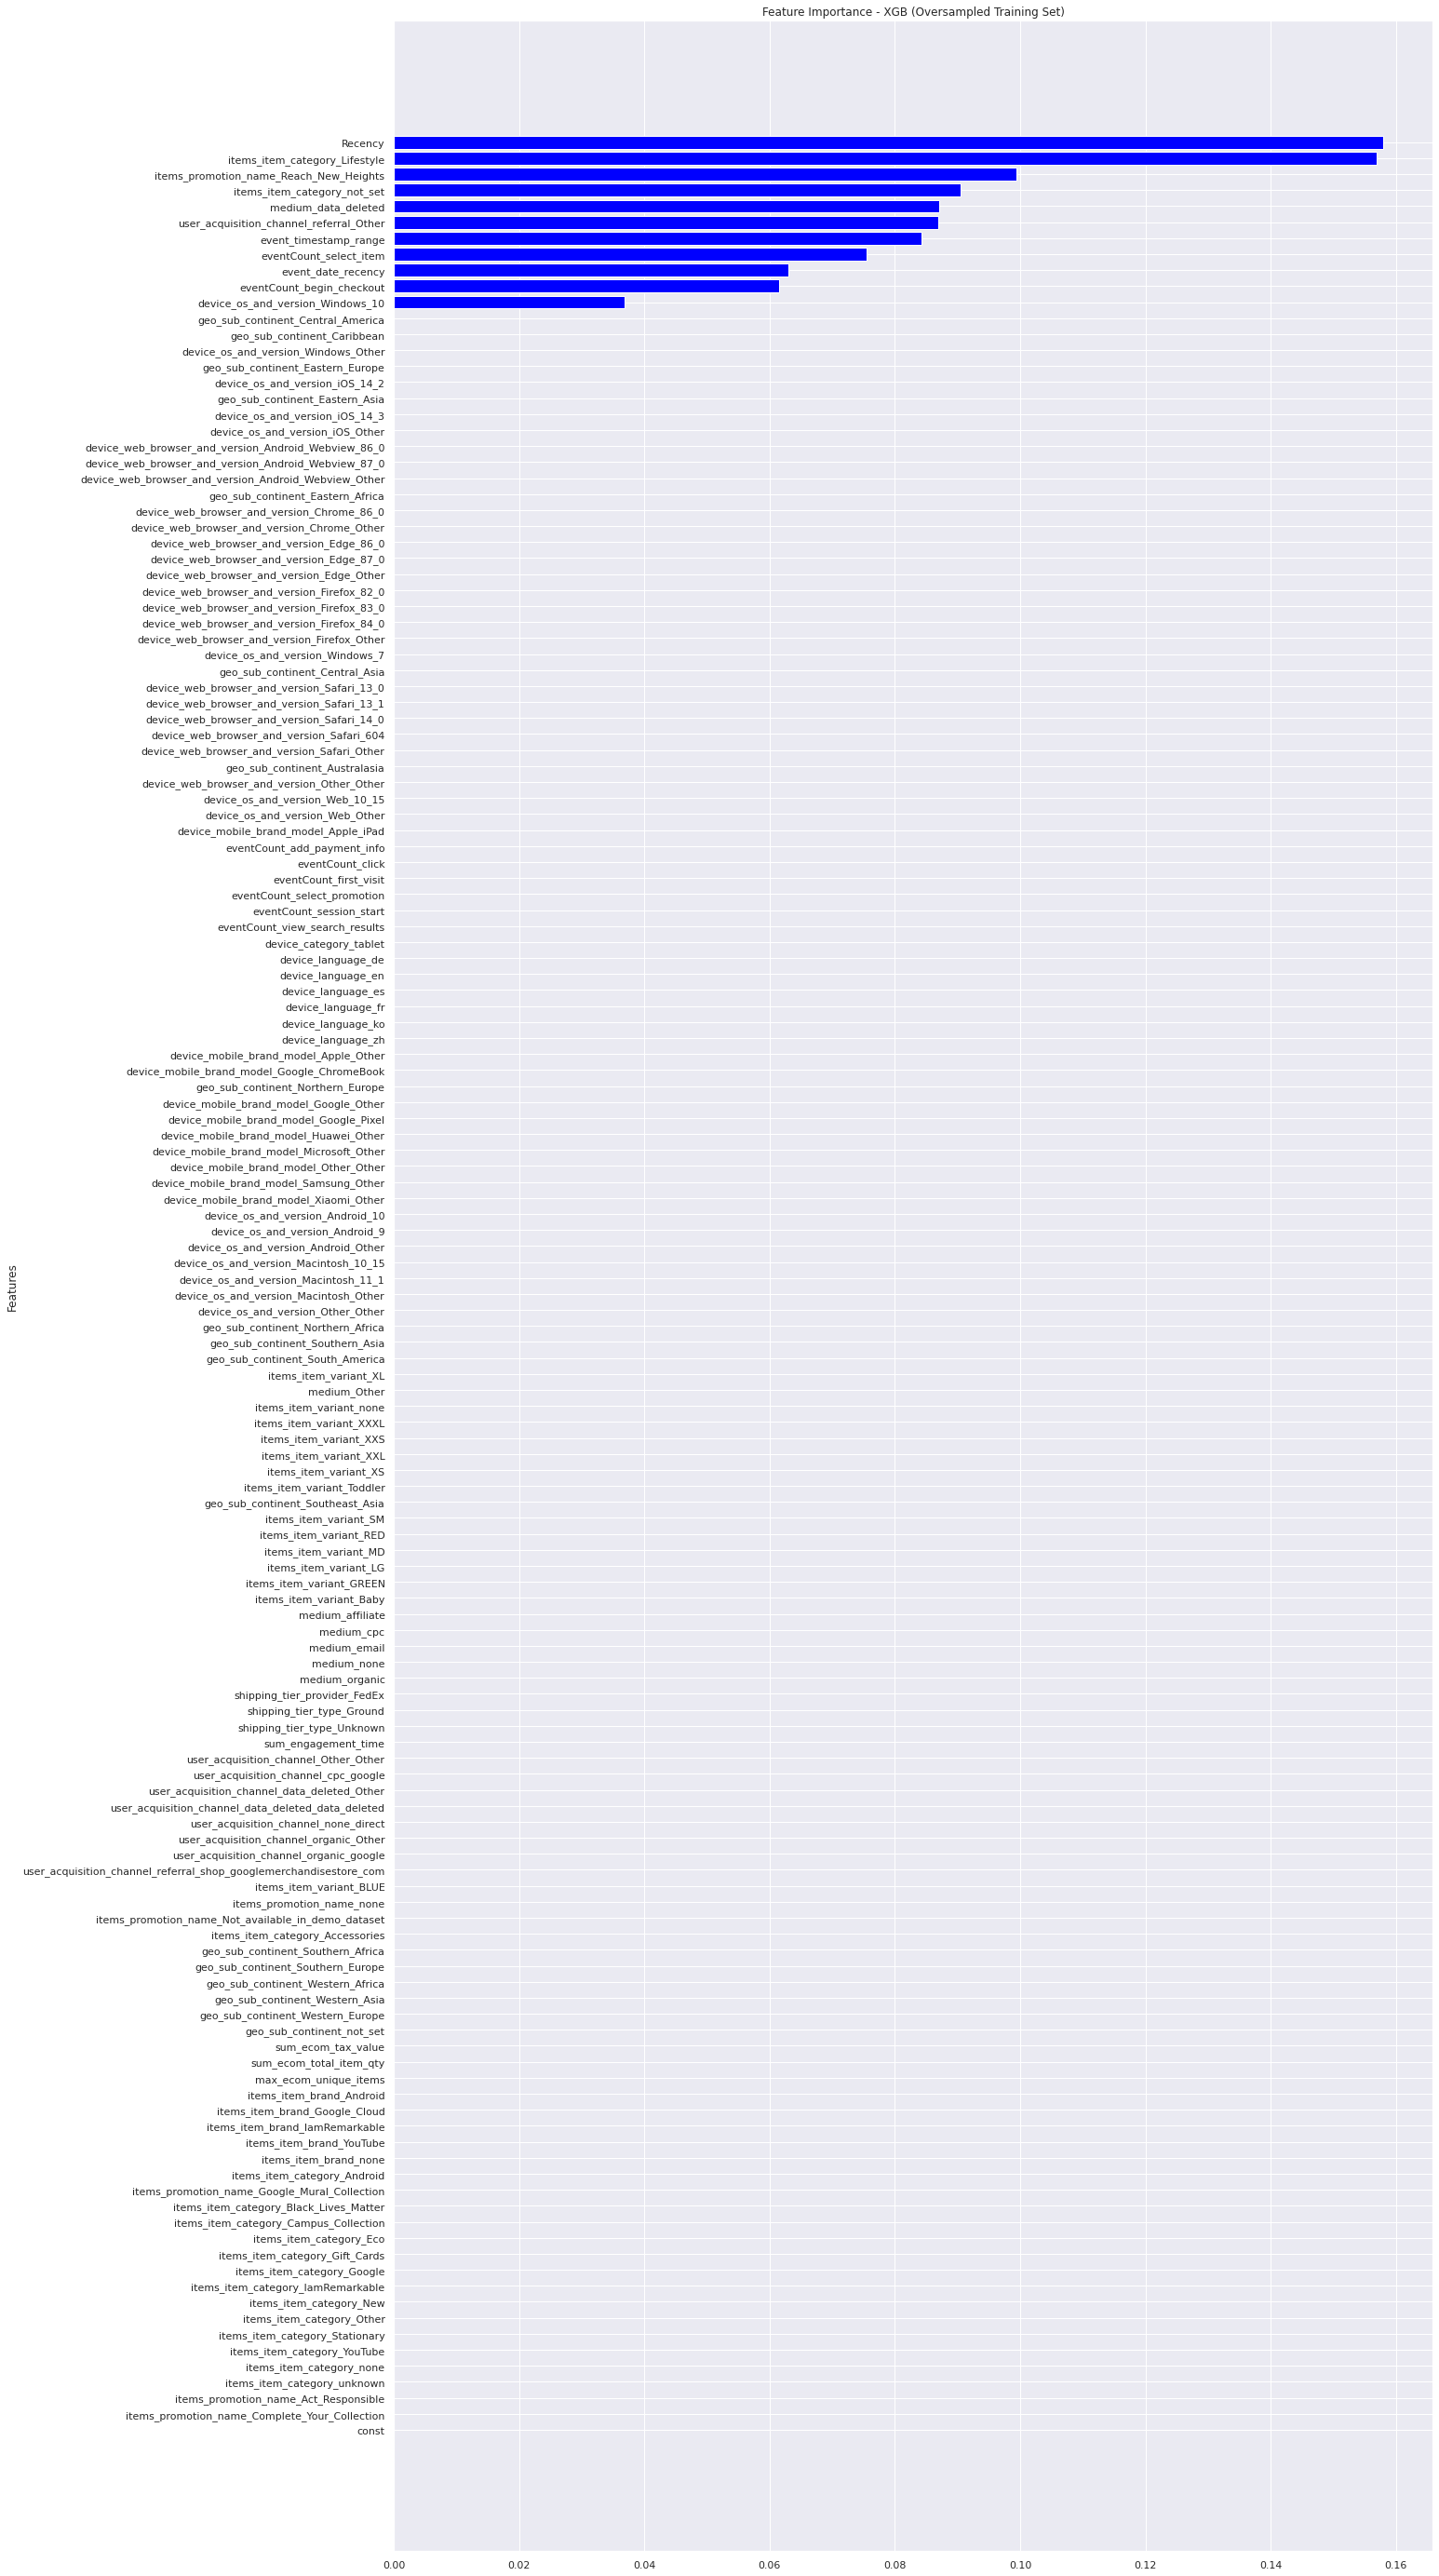

In [ ]:
feature_names = X_train_over.columns
importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 50))
plt.title("Feature Importance - XGB (Oversampled Training Set)")
plt.barh(range(len(indices)), importances[indices], color="blue")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.ylabel("Features")
plt.show()

It appears that a handful of features are very important in the model, while the majority don't influence it at all. 

If you're interested in refining your model further, you can go back and try different methods of feature engineering, such creating different groupings or labels within certain categorical features (e.g. removing device browser version and grouping just by device browser).

## Classification Analysis

In [ ]:
# get prediction probabilities for val 
pred_val = xgb.predict(X_val)
prob_val = xgb.predict_proba(X_val)

In [ ]:
# get prediction probabilities for test
pred_test = xgb.predict(X_test)
prob_test = xgb.predict_proba(X_test)

In [ ]:
# create a dataframe of val results
result_val = pd.DataFrame(
    np.transpose([y_val, pred_val, prob_val[:, 1]]),
    columns=["Original", "Predicted", "Probability"],
)

In [ ]:
# create a dataframe of test results
result_test = pd.DataFrame(
    np.transpose([y_test, pred_test, prob_test[:, 1]]),
    columns=["Original", "Predicted", "Probability"],
)

In [ ]:
# function to add classification labels
def Label(df):
    if (df["Predicted"] == 0) & (df["Original"] == 0):
        return "TN"

    elif (df["Predicted"] == 1) & (df["Original"] == 1):
        return "TP"

    elif df["Predicted"] > df["Original"]:
        return "FP"

    elif df["Predicted"] < df["Original"]:
        return "FN"

In [ ]:
# apply function to val and test dataframes
result_val["Label"] = result_val.apply(Label, axis=1)
result_test["Label"] = result_test.apply(Label, axis=1)

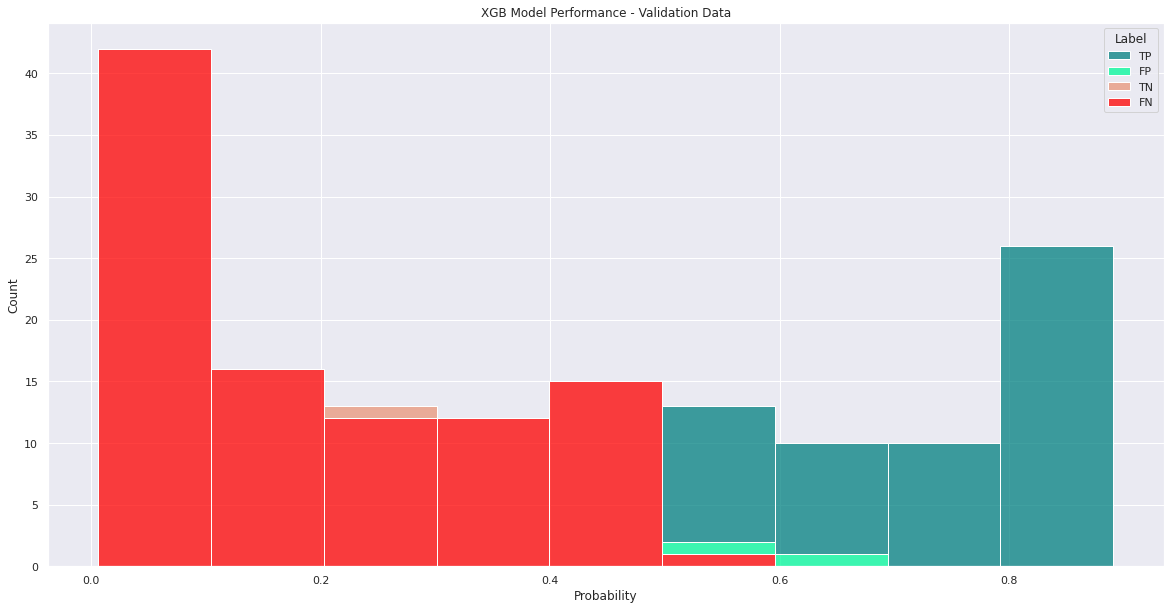

In [ ]:
# plot val probabilities
hue_order = ['TP', 'FP', 'TN','FN']
palette ={"TP": "teal", "FP": "mediumspringgreen", "TN": "darksalmon", "FN": "red"}
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(data=result_val, x="Probability", hue="Label",multiple="stack",palette=palette,hue_order=hue_order).set(title='XGB Model Performance - Validation Data')
plt.show();

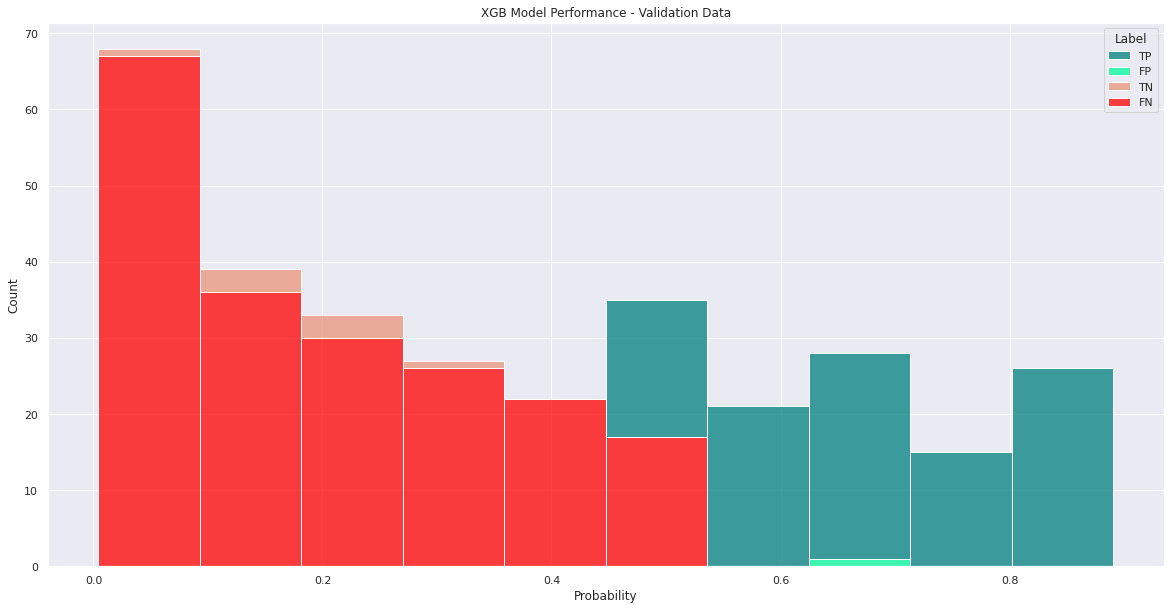

In [ ]:
# plot test probabilities
hue_order = ['TP', 'FP', 'TN','FN']
palette ={"TP": "teal", "FP": "mediumspringgreen", "TN": "darksalmon", "FN": "red"}
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(data=result_test, x="Probability", hue="Label",multiple="stack",palette=palette,hue_order=hue_order).set(title='XGB Model Performance - Validation Data')
plt.show();

# Conclusion

In this series of notebooks, you've learned to:
1. Analyze, preprocess, and engineer a GA4 dataset from BigQuery,
2. Build, tune and evaluate an XGBoost Classifier model, and
3. Drop the results into a table for visualization and further analysis.

One of the most important things to remember is that the metric you choose to optimize to should depend on your business needs. In this example, we optimized to correctly identifying as many True Negatives as possible, for a range of potential reasons. For example, we may want to create marketing audiences that help us find and market to new customers who look like our existing customers with low churn propensities. 

You may choose instead to optimize your model to recall, precision, or F1 score depending on your specific business use case. 